In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import gc
import matplotlib.pyplot as plt  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
skip_start = True

# Import data

In [3]:
if not skip_start:
    train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
    train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')
    train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
    print(train.shape)
    del train_identity, train_transaction
    gc.collect()
    train.to_pickle("train.pkl")
else:
    train = pd.read_pickle("train.pkl")
#     train = train.sample(200000)

In [4]:
y = train['isFraud']   # target class
X = train.drop('isFraud', axis=1)
print(X.shape, y.shape)

(590540, 433) (590540,)


In [5]:
del train
gc.collect()

40

# split data into test and train

In [6]:
X_train_hold, X_test_hold, y_train_hold, y_test_hold = train_test_split(X, y, test_size=0.5, random_state=42)
X_train_hold.shape, X_test_hold.shape, y_train_hold.shape, y_test_hold.shape

((295270, 433), (295270, 433), (295270,), (295270,))

In [7]:
del X, y
gc.collect()

40

# Now work on train

### Parameters to tune:

In [8]:
threshold_column_missing = 0.22 # more than this number is not used

In [9]:
correct_bias_isFruad_times_multiply = 3 # x times as many not fraud as fraud

## handle bias in data for isFraud

In [10]:
X_train = X_train_hold.copy()

In [11]:
X_train.loc[:, 'isFraud'] = y_train_hold

In [12]:
total_is_fraud = X_train[X_train["isFraud"] == 1]["isFraud"].value_counts().item()
total_is_not_fraud = X_train[X_train["isFraud"] == 0]["isFraud"].value_counts().item()
(X_train
    .filter(['isFraud'])
    .value_counts()
)

isFraud
0          285043
1           10227
dtype: int64

In [13]:
X_train = X_train[X_train["isFraud"] == 1].append(X_train[X_train["isFraud"] == 0].sample(total_is_fraud*correct_bias_isFruad_times_multiply))
X_train.shape

(40908, 434)

In [14]:
(X_train
    .filter(['isFraud'])
    .value_counts()
)

isFraud
0          30681
1          10227
dtype: int64

In [15]:
y_train = X_train.loc[:, 'isFraud']
X_train.drop(labels=['isFraud'], axis=1, inplace = True)

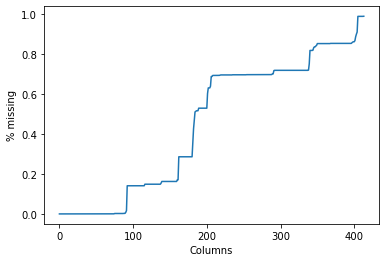

In [16]:
data = [(col, X_train[col].isnull().sum() / len(X_train)) 
        for col in X_train.columns if X_train[col].isnull().sum()]
col_names = ['column', 'percent_missing']
missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
missing_df.sort_values(["percent_missing"], ascending=True, inplace=True)
missing_df.reset_index(inplace=True)


plt.plot(missing_df.percent_missing)
plt.xlabel('Columns')
plt.ylabel('% missing')
plt.show()

In [17]:
print("dropping:")
dropped_columns = X_train.loc[:,
    (X_train
        .isna()
        .mean()
        .ge(threshold_column_missing)
     )
].columns.tolist()
dropped_columns

dropping:


['dist1',
 'dist2',
 'R_emaildomain',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D11',
 'D12',
 'D13',
 'D14',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V

In [18]:
X_train.drop(columns=dropped_columns, inplace=True)
transactionID = X_train.pop("TransactionID")

In [19]:
start = dt.datetime(2021,1,1,0,0) # need a reference point use this for train and test
X_train.loc[:, "TransactionDT"] = X_train["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()

In [20]:
X_train

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
370739,Saturday,10.392,C,9633,130.0,185.0,visa,138.0,debit,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
473420,Saturday,68.950,W,11727,301.0,150.0,mastercard,224.0,debit,485.0,...,0.000000,67.949997,67.949997,67.949997,0.0,0.000000,0.000000,0.0,0.000000,0.000000
85573,Thursday,38.012,C,2650,142.0,185.0,mastercard,224.0,debit,NaN,...,26.409901,0.000000,26.409901,26.409901,0.0,236.931198,236.931198,0.0,158.342804,158.342804
240268,Sunday,226.000,W,1675,174.0,150.0,visa,226.0,debit,330.0,...,49.000000,49.000000,98.000000,49.000000,226.0,226.000000,226.000000,176.0,176.000000,176.000000
179343,Monday,280.000,W,16075,514.0,150.0,mastercard,102.0,credit,123.0,...,335.000000,335.000000,335.000000,335.000000,889.0,889.000000,889.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41925,Tuesday,50.000,W,4141,404.0,150.0,mastercard,102.0,credit,204.0,...,105.000000,105.000000,105.000000,105.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
475330,Sunday,83.950,W,17188,321.0,150.0,visa,226.0,debit,299.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
93702,Saturday,82.950,W,3870,555.0,150.0,visa,226.0,debit,299.0,...,0.000000,159.949997,159.949997,159.949997,0.0,0.000000,0.000000,0.0,0.000000,0.000000
468580,Thursday,34.000,W,4576,310.0,150.0,mastercard,224.0,debit,203.0,...,0.000000,26.500000,109.500000,26.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [21]:
X_train.dtypes

TransactionDT      object
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
                   ...   
V317              float64
V318              float64
V319              float64
V320              float64
V321              float64
Length: 180, dtype: object

In [22]:
numeric_features = make_column_selector(dtype_include=['float64','int64'])
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())])

In [23]:
categorical_features = make_column_selector(dtype_include='object')
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [25]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('pca', PCA(n_components=50)),
                      ('classifier', SVC())],
               verbose=True)

In [26]:
ss = ShuffleSplit(test_size=0.5, n_splits=1, random_state=7)

In [27]:
param_grid = [{
                  'classifier': (KNeighborsClassifier(),),
                  'classifier__n_neighbors':[20], 
                  'classifier__metric':['manhattan'],
                  'classifier__weights':['distance'],
                  'pca__n_components':[100]        
              },
              {
                  'classifier': (SVC(gamma="auto",probability=True),),
                  'pca__n_components':[100]  
              },
              {
                  'classifier': (MLPClassifier(hidden_layer_sizes=(100,), max_iter=20, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1),),
                  'pca__n_components':[100],
                  'classifier__alpha':[1e-6],
                  'classifier__hidden_layer_sizes':[(50,)],
                  'classifier__max_iter':[100],
                  'classifier__learning_rate_init':[0.01],
              },
                  {
                  'classifier': (LogisticRegression(solver='liblinear'),),
                  'pca__n_components':[100]  
              }
              ]


In [28]:
pipe_gs = GridSearchCV(pipe, param_grid, cv=ss, scoring="roc_auc",
                      verbose = 10, n_jobs = -1)

In [29]:
pipe_gs = pipe_gs.fit(X_train, y_train)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total= 7.2min
[Pipeline] ............... (step 2 of 3) Processing pca, total=   1.7s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


In [30]:
pipe_gs.best_params_

{'classifier': KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance'),
 'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 20,
 'classifier__weights': 'distance',
 'pca__n_components': 100}

In [31]:
pipe_gs.cv_results_

{'mean_fit_time': array([ 817.17983317, 1076.82515192,  827.12853312,  818.80977273]),
 'std_fit_time': array([0., 0., 0., 0.]),
 'mean_score_time': array([426.94508457, 223.2392695 , 374.09607482, 382.75462198]),
 'std_score_time': array([0., 0., 0., 0.]),
 'param_classifier': masked_array(data=[KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance'),
                    SVC(gamma='auto', probability=True),
                    MLPClassifier(learning_rate_init=0.1, max_iter=20, random_state=1, solver='sgd',
                                  verbose=0)                                                        ,
                    LogisticRegression(solver='liblinear')],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__metric': masked_array(data=['manhattan', --, --, --],
              mask=[False,  True,  True,  True],
        fill_value='?',
             dtype=object),
 'param_classifier__n_neigh

In [32]:
(pd.concat([pd.DataFrame(pipe_gs
                        .cv_results_["params"]),
           pd.DataFrame(pipe_gs.cv_results_["mean_test_score"],
                        columns=["roc_auc"])],
          axis=1)
 .sort_values("roc_auc",ascending=False)
)


,classifier,classifier__metric,classifier__n_neighbors,classifier__weights,pca__n_components,classifier__alpha,classifier__hidden_layer_sizes,classifier__learning_rate_init,classifier__max_iter,roc_auc
0,"KNeighborsClassifier(metric='manhattan', n_nei...",manhattan,20.0,distance,100,NaN,NaN,NaN,NaN,0.844342
2,"MLPClassifier(learning_rate_init=0.1, max_iter...",NaN,NaN,NaN,100,0.000001,"(50,)",0.01,100.0,0.837979
1,"SVC(gamma='auto', probability=True)",NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,0.832869
3,LogisticRegression(solver='liblinear'),NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,0.810478


# test model on hold out test from above

In [33]:
X_test_hold.drop(columns=dropped_columns, inplace=True)
transactionID = X_test_hold.pop("TransactionID")
X_test_hold.loc[:, "TransactionDT"] = X_test_hold["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()

In [34]:
len(list(X_test_hold.columns))

180

In [35]:
y_pred_gs = pipe_gs.predict(X_test_hold)

In [36]:
print("Accuracy: {0:4.2f}".format(accuracy_score(y_test_hold,y_pred_gs)))

Accuracy: 0.94


In [37]:
y_test_hold_probs = pipe_gs.predict_proba(X_test_hold)[:, 1]

In [38]:
print("roc_auc_score: {0:4.2f}".format(roc_auc_score(y_test_hold, y_test_hold_probs)))

roc_auc_score: 0.87


In [39]:
from joblib import dump, load
dump(pipe_gs, 'pipe_gs1.joblib') 

['pipe_gs1.joblib']

In [40]:
# raise Exception("Stop right here!") 

# Finally predict the Kaggle test data set

In [61]:
test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
transactionID = test.pop("TransactionID")
test.shape

(506691, 432)

In [62]:
test.columns=test.columns.str.replace('-','_')

In [63]:
test.drop(columns=dropped_columns, inplace=True)

In [64]:
test.loc[:, "TransactionDT"] = test["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()

In [65]:
len(list(test.columns))

180

In [66]:
test_isFraud_prob = pipe_gs.predict_proba(test)[:, 1]

In [69]:
submission = pd.DataFrame({"TransactionID": transactionID, "isFraud": test_isFraud_prob}) 
submission.to_csv("data/submission.csv", index=False)